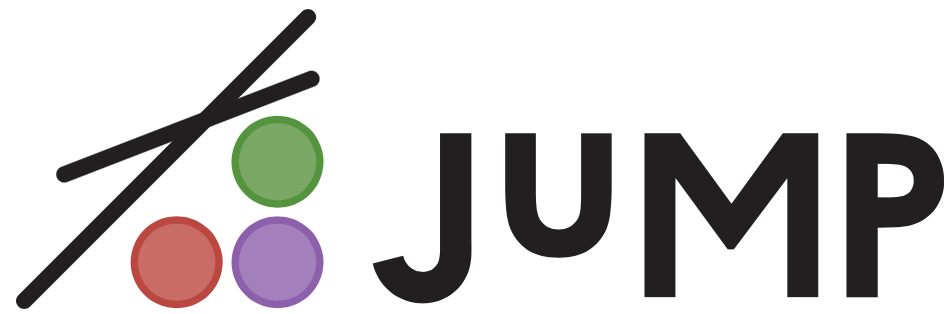

# A mathematical modeling language for Julia

- Dr. Oscar Dowson
- Northwestern University, Evanston, IL.
- Core JuMP developer
- o.dowson@gmail.com
- https://jump.dev

This notebook is available at 
https://github.com/odow/jump-talk-data-science-learning

# Agenda

- What is JuMP?
- A simple example
- Why (not) use JuMP?
- A fancier example
- How to collaborate and deploy
- JuMP driving the state-of-the art

# What is JuMP?

- JuMP is an algebraic modeling language embedded in Julia
- Similar to AMPL, PuLP, Pyomo,...
- It can be used for 
    - linear, mixed-integer, conic, and nonlinear programming
- We connect to all your favorite solvers
    - Cbc, Clp, CPLEX, GLPK, Gurobi, Ipopt, Mosek, SCS...
- Started as a research project at MIT in 2012
    - Now a globally distributed open-source project
    - Annual conference series USA (2017), France (2018), Chile (2019), Belgium (2020)
        - https://jump.dev/meetings/louvain2020/
    - Used by 10'000s of people in academia and industry
        - Energy consultanting firms
        - Logistics firms
        - Multi-national agri-businesses
        - Some of your clients!

# A simple example


$$\begin{array}{r l}\min & 2x + y\\\text{subject to}& x + y \ge 3\\& 0 \le x\\& 1 \le y \le 2\end{array}$$

In [ ]:
using JuMP  # from JuMP import *
import GLPK # import GLPK

model = Model(GLPK.Optimizer)
@variable(model, 0 <= x)
@variable(model, 1 <= y <= 2)
@objective(model, Min, 2x + y)
@constraint(model, my_con, x + y >= 3)

println("=== Model ===")
print(model)

optimize!(model)

println("=== Solution ===")
println("status        = ", termination_status(model))
println("objective     = ", objective_value(model))
println("primal_status = ", primal_status(model))
println("x             = ", value(x))
println("y             = ", value(y))
println("dual_status   = ", dual_status(model))
println("my_con        = ", dual(my_con))

# Why not use JuMP?

_This is not a sugar-coated talk_

1. You have to add _another_ language to your stack
2. Julia/JuMP doesn't have millions of questions on Stackoverflow
3. Julia has a start-up compilation cost

If your use-case is "Build a simple LP, then solve it on a production server every 5 seconds for the next 10 years", JuMP isn't for you (right now).

In [ ]:
# Time starting Julia and importing JuMP
@time run(`julia --project=. -e "using JuMP"`)

# Time starting Python and importing PuLP
@time run(`/usr/local/bin/python3 -c "from pulp import *"`)

# Why use JuMP?

1. Syntax
2. Fast
    - Code speed¹
    - **More importantly: development speed**
3. Can model spectrum of problems from linear programs through to mixed-integer nonlinear
4. We offer advanced features
    - Solver-independent callbacks
        - Lazy constraints
        - User cuts
        - Heuristic solutions
    - Best status reporting system
        - Termination, primal, and dual statuses
        


¹_Ignoring the initial compliation overhead._

# Ideal use-case

- New project with unclear requirements
    - Not sure if its linear, quadratic, nonlinear
    - Might need integer variables
    - Might need custom heuristics
- Limited time-frame necessitates rapid prototyping
- Prototype can be moved into production

## Use-case 1: forward deployment of ventilators

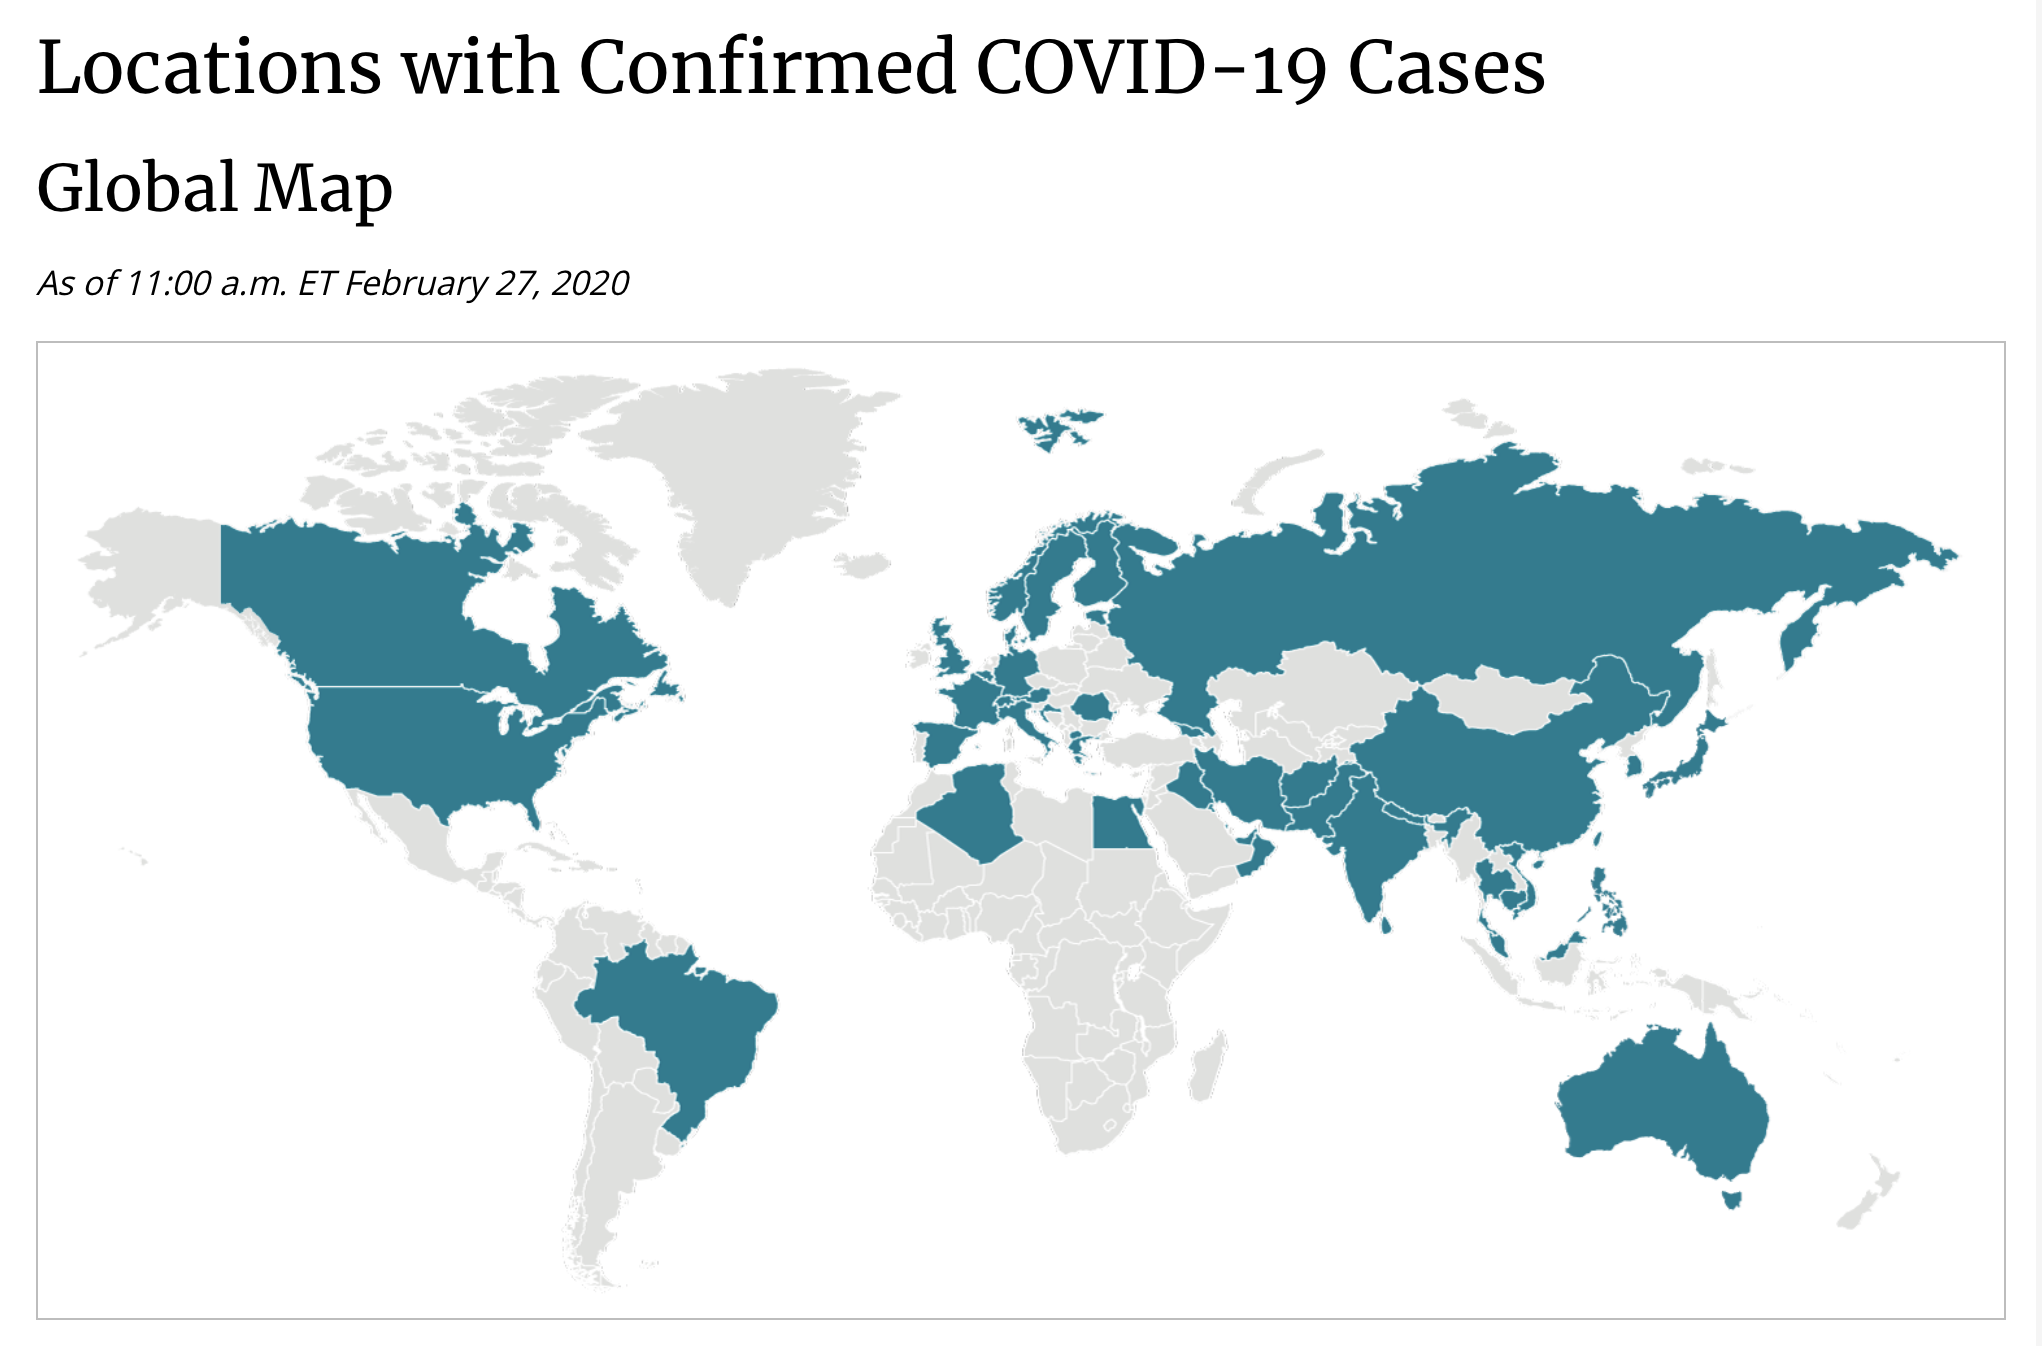

## Use-case 2: compute-heavy consulting

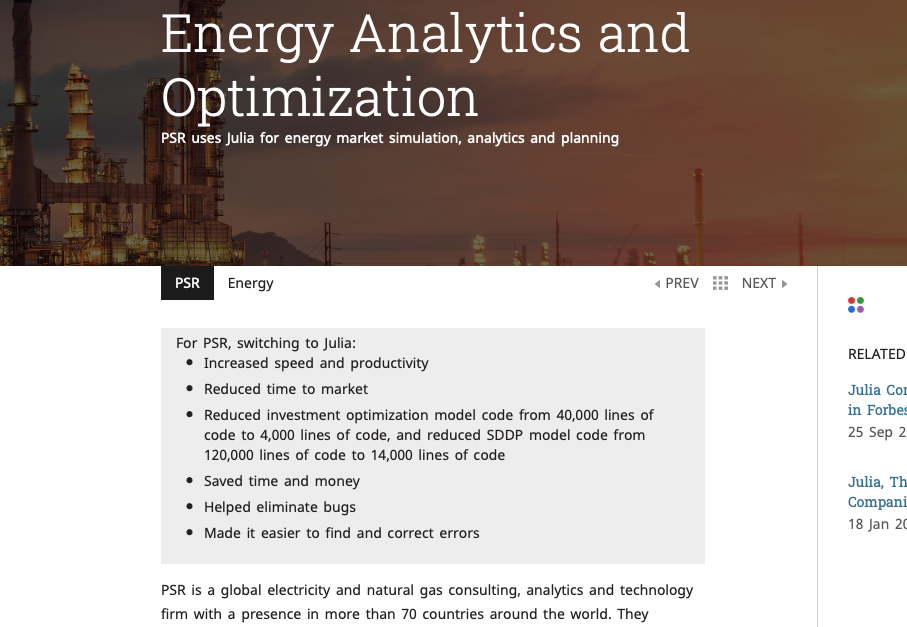

## Use-case 3: open-source

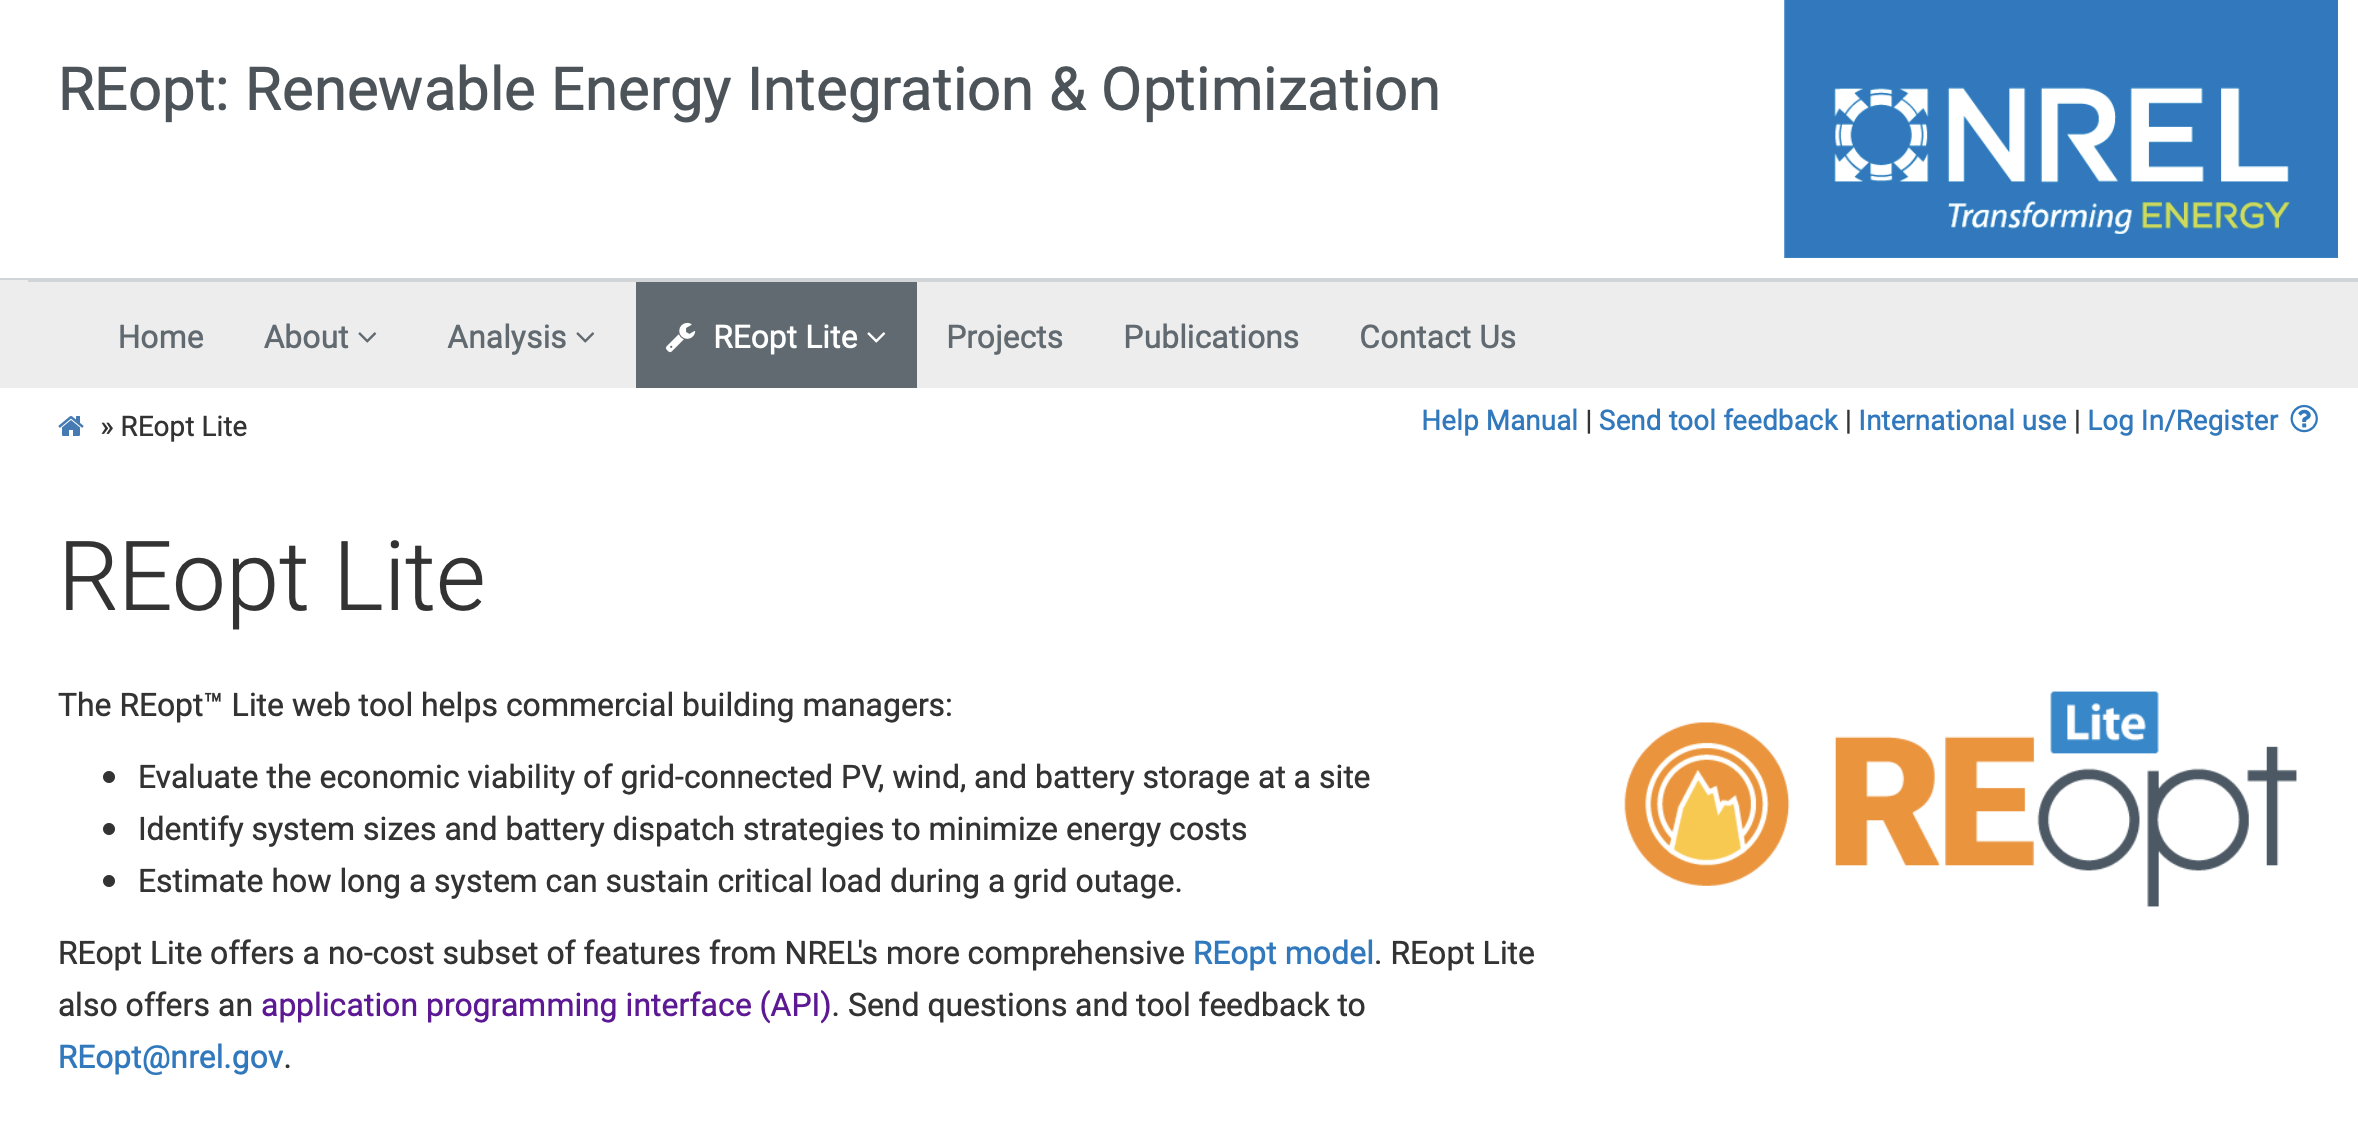

## A fancier example

The famous diet (Whiskas) problem from the PuLP documentation:
https://pythonhosted.org/PuLP/CaseStudies/a_blending_problem.html

In [ ]:
; cat pulp_example.py

In [ ]:
; cat data.json

In [ ]:
run(`/usr/local/bin/python3 pulp_example.py data.json --verbose`)

In [ ]:
using GLPK
using JSON
using JuMP

function run_diet_model(filename::String; verbose::Bool = true)
    data = JSON.parsefile(filename)
    
    Ingredients = collect(keys(data))

    model = Model(GLPK.Optimizer)
    @variable(model, quantity[i = Ingredients] >= 0)
    @objective(
        model, 
        Min, 
        sum(data[i]["cost"] * quantity[i] for i in Ingredients)
    )
    @constraints(model, begin
        sum(quantity) == 100
        sum(data[i]["protein"] * quantity[i] for i in Ingredients) >= 8
        sum(data[i]["fat"] * quantity[i] for i in Ingredients) >= 6
        sum(data[i]["fibre"] * quantity[i] for i in Ingredients) <= 2
        sum(data[i]["salt"] * quantity[i] for i in Ingredients) <= 0.4
    end)

    optimize!(model)
    println("Status: ", termination_status(model))
    if verbose
        for v in Ingredients
            println(v, " = ", value(quantity[v]))
        end
    end
    println("Total cost of Ingredients per can = ", objective_value(model))
end

println("=== Complilation run ===")
t = time()
run_diet_model("data.json")
println("Run time (s) = ", time() - t)

println("=== Second run ===")
t = time()
run_diet_model("data.json")
println("Run time (s) = ", time() - t)

The difference in run-time is exacerbated as the problem size gets larger

In [ ]:
using JSON
let data = JSON.parsefile("data.json")
    ingredients = collect(keys(data))
    for n = 1:20_000
        for i in ingredients
            d = copy(data[i])
            d["cost"] = (0.5 + rand()) * data[i]["cost"]
            data["$(i)_$(n)"] = d
        end
    end
    open("data_big.json", "w") do io
        write(io, JSON.json(data))
    end
end

In [ ]:
run(`/usr/local/bin/python3 pulp_example.py data_big.json`)

t = time()
run_diet_model("data_big.json"; verbose = false)
println("Run time (s) = ", time() - t)

## More complicated models

JuMP has powerful syntax for expressing complicated variables and constraints.

We can create a `DenseAxisArray` of variables:

In [ ]:
model = Model()
S = ["tauranga", "auckland"]
@variable(model, x[i = 1:4, S] >= i)

x

In [ ]:
lower_bound(x[3, "auckland"])

In [ ]:
sum(x[:, "auckland"])

In [ ]:
sum(x[3, :])

We can also create _sparse_ arrays of variables:

In [ ]:
model = Model()
S = ["tauranga", "auckland"]
@variable(model, x[i = 1:4, S; isodd(i)] >= i)
x

In [ ]:
sum(x[i] for i in eachindex(x) if i[2] == "tauranga")

In [ ]:
model = Model()
@variable(model, 🐱, Int)
@variable(model, x[1:3])
@constraint(model, 🐱 >= sum(x.^2))
@objective(model, Min, 🐱)
model

## Solver-independent callbacks

In [ ]:
using GLPK
using JuMP

model = Model(GLPK.Optimizer)

@variable(model, 0 <= x[1:2] <= 2.5, Int)
@objective(model, Max, x[2])

function my_callback_function(cb_data)
    x_val = map(xi -> callback_value(cb_data, xi), x)
    println("Lazy constraint called at x = $x_val")
    if x_val[2] - x_val[1] > 1 + 1e-6
        println("    Constraint violated 😢")
        println("    Adding cut x[2] <= 1 + x[1]")
        MOI.submit(
            model, MOI.LazyConstraint(cb_data), 
            @build_constraint(x[2] <= 1 + x[1])
        )
    elseif x_val[2] + x_val[1] > 3 + 1e-6
        println("    Constraint violated")
        println("    Adding cut x[2] <= 3 - x[1]")
        MOI.submit(
            model, MOI.LazyConstraint(cb_data), 
            @build_constraint(x[2] <= 3 - x[1])
        )
    else
        println("    Constraints satisfied!")
    end
end

MOI.set(model, MOI.LazyConstraintCallback(), my_callback_function)

optimize!(model)

@show termination_status(model)
@show primal_status(model)
@show value.(x)

# Nonlinear modeling made easy

In [ ]:
using Ipopt

rocket = Model(Ipopt.Optimizer)
set_silent(rocket)

h_0 = 1    # Initial height
v_0 = 0    # Initial velocity
m_0 = 1    # Initial mass
g_0 = 1    # Gravity at the surface

T_c = 3.5  # Used for thrust
h_c = 500  # Used for drag
v_c = 620  # Used for drag
m_c = 0.6  # Fraction of initial mass left at end

c     = 0.5 * sqrt(g_0 * h_0)  # Thrust-to-fuel mass
m_f   = m_c * m_0            # Final mass
D_c   = 0.5 * v_c * m_0 / g_0    # Drag scaling
T_max = T_c * g_0 * m_0        # Maximum thrust

n = 800   # Time steps

@variables(rocket, begin
    Δt ≥ 0, (start = 1/n)
    # State variables
    v[1:n] ≥ 0            # Velocity
    h[1:n] ≥ h_0          # Height
    m_f ≤ m[1:n] ≤ m_0    # Mass
    # Control
    0 ≤ T[1:n] ≤ T_max    # Thrust
end)

# Objective: maximize altitude at end of time of flight
@objective(rocket, Max, h[n])

# Initial conditions
@constraints(rocket, begin
    v[1] == v_0
    h[1] == h_0
    m[1] == m_0
    m[n] == m_f
end)

# Forces
@NLexpressions(rocket, begin
    drag[j = 1:n], D_c * (v[j]^2) * exp(-h_c * (h[j] - h_0) / h_0)
    grav[j = 1:n], g_0 * (h_0 / h[j])^2
    accel[j = 1:n], (T[j] - drag[j]) / m[j] - grav[j]
end)

# Dynamics
@NLconstraints(rocket, begin
    # Height: h' = v
    [j=2:n], h[j] == h[j - 1] + 0.5 * Δt * (v[j] + v[j - 1])
    # Velocity: v' = (T - D(h, v)) / m - g(h)
    [j=2:n], v[j] == v[j-1] + 0.5 * Δt * (accel[j] + accel[j - 1])
    # Mass: m' = -T/c
    [j=2:n], m[j] == m[j - 1] - 0.5 * Δt * (T[j] + T[j-1]) / c
end)

optimize!(rocket)
println("Max height: ", objective_value(rocket))

using Plots

plot(
    plot(
        value(Δt) .* (1:n), 
        value.(h), 
        legend = false,
        title = "Height",
    ),
    plot(
        value(Δt) .* (1:n), 
        value.(v), 
        legend = false,
        title = "Velocity",
    ),
    plot(
        value(Δt) .* (1:n), 
        value.(m), 
        legend = false,
        title = "Mass",
    ),
    plot(
        value(Δt) .* (1:n), 
        value.(T), 
        legend = false,
        title = "Thrust",
    )
)

## How to collaborate

Julia makes it easy to collaborate on projects because of the versioning system built into the package manager.

**TL;DR: Julia has built-in support for virtual environments. By sharing `Manifest.toml` file, you can reproduce the exact set of packages on any machine.**

Read more at: https://julialang.github.io/Pkg.jl/v1/

In [ ]:
import Pkg
Pkg.status()

Package compatibility is governed by a `Project.toml` file, which specifies the list of packages you require, along with compatibility bounds following [Semantic Versioning](https://semver.org).

In [ ]:
; cat Project.toml

It also has a `Manifest.toml` file, which locks _all_ dependencies to the _exact_ git commit that is currently installed.

In [ ]:
; cat Manifest.toml

Environments can be initialized by starting Julia with the `--project=/path/to/Manifest` flag

In [ ]:
run(`julia --project=/Users/Oscar/.julia/dev/SDDP -e 'import Pkg; Pkg.status()'`);

In [ ]:
run(`julia --project=/Users/Oscar/Documents/People/Simon\ Bull -e 'import Pkg; Pkg.status()'`);

# How to deploy

- The deployment story if Julia isn't great
    - In some cases, can create binaries
    - ~500 Mb since need entire Julia run-time
- Dockerize
    - Serve from webserver
    - Start Julia instances on demand
        - This is what REOpt does
    - Have long-running process with Julia/JuMP precompiled listening for requests
        - We will be doing for COVID-19

## Long-term sustainability

1. Academia
    - Taught to students
    - Bulk of development done by grad students
    - Pay people like me to work on it
2. Community
    - JuMP is free and open-source
    - Community forum for support: https://discourse.julialang.org/c/domain/opt/13
    - JuMP is part of [NumFOCUS](https://numfocus.org), a U.S. 501(c)(3) non-profit 
3. Government/Industry
    - Companies use JuMP in production
    - Hire developers to work on JuMP
    - Donate to NumFOCUS
    
## Where to learn more


- Google "JuMP.jl"
- https://jump.dev
- https://github.com/JuliaOpt/JuMPTutorials.jl
- https://github.com/odow/jump-talk-data-science-learning